In [2]:
# importing necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as sp
import math
import statistics


In [3]:
# Uploading csv files 
reservations = pd.read_csv('Premiere_Nation_First_Nation.csv')
health_centres = pd.read_csv('canada_healthcare_centres.csv', encoding = "ISO-8859-1")

health_centres

,index,facility_name,source_facility_type,odhf_facility_type,provider,unit,street_no,street_name,postal_code,city,province,source_format_str_address,CSDname,CSDuid,Pruid,latitude,longitude
0,1,Advanced Facial & Nasal Surgery Centre,other,Ambulatory health care services,Canadian Institute for Health Information,NaN,NaN,NaN,T5M 4G5,edmonton,ab,NaN,Edmonton,NaN,48,NaN,NaN
1,10,Alberta Children's Hospital,pediatric,Hospitals,Public Health Agency of Canada,NaN,28,oki dr nw,T3B 6A8,calgary,ab,28 Oki Dr NW,Calgary,4806016.0,48,51.074582,-114.148426
2,100,Devon General Hospital,general,Hospitals,Public Health Agency of Canada,NaN,101,erie st s,T9G 1A6,devon,ab,101 erie st. s. devon ab t9g 1a6,Devon,4811018.0,48,53.351493,-113.730785
3,1000,Kimbelee Place,NaN,Nursing and residential care facilities,Province of British Columbia,NaN,12935,96 ave,V3V 7K6,surrey,bc,12935 96th ave surrey bc v3v 7k6,Surrey,5915004.0,59,49.177418,-122.864118
4,1001,Kimberley Special Care Home,NaN,Nursing and residential care facilities,Province of British Columbia,NaN,386,2 ave,V1A 2Z6,kimberley,bc,386 2 ave kimberley bc v1a 2z6,Kimberley,5901028.0,59,49.689998,-115.989647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,S995,CENTRE MULTISERVICES DE SANTÉ ET DE SERVICES S...,"CHSGS, CLSC, CHSLD, CRDITED, CRD",Hospitals,Province of Québec,NaN,1070,boulevard docteur-camille-marcoux,G0G 1W0,blanc-sablon,qc,"1070, boulevard Docteur-Camille-Marcoux",Blanc-Sablon,2498005.0,24,51.411577,-57.203155
7029,S996,CLSC DE LOW,CLSC,Ambulatory health care services,Province of Québec,NaN,334,route 105,J0X 2C0,low,qc,"334, route 105",Low,2483010.0,24,45.809213,-75.949661
7030,S997,CLSC DE SAINT-JEAN-DE-DIEU,CLSC,Ambulatory health care services,Province of Québec,NaN,20,rue de la villa,G0L 3M0,saint-jean-de-dieu,qc,"20, rue de la Villa",Saint-Jean-de-Dieu,2411010.0,24,48.006409,-69.041224
7031,S998,CLSC DE SAINT-PASCAL,CLSC,Ambulatory health care services,Province of Québec,NaN,595,avenue martin,G0L 3Y0,saint-pascal,qc,"595, avenue Martin",Saint-Pascal,2414018.0,24,47.529403,-69.803406


In [11]:
# Cleaning the indigenous reservation dataset, keeping only longitude and latitude columns
reservation_coords = pd.DataFrame().assign(longitude=reservations['LONGITUDE'], latitude=reservations['LATITUDE'])
reservation_coords = reservation_coords[reservation_coords['latitude'].notna()]
reservation_coords = reservation_coords[reservation_coords['longitude'].notna()]
reservation_coords

,longitude,latitude
0,-123.697181,48.384648
1,-102.861137,53.490952
2,-122.194645,49.055278
3,-120.240793,50.986697
4,-90.229492,51.092136
...,...,...
632,-125.577923,64.900537
633,-109.626874,54.408436
634,-81.683575,52.215309
635,-84.150200,46.536849


In [12]:
# Cleaning the healthcare centres dataset, keeping only longitude and latitude columns
health_centre_coords = pd.DataFrame().assign(longitude=health_centres['longitude'], latitude=health_centres['latitude'])
health_centre_coords = health_centre_coords[health_centre_coords['longitude'].notna()]
health_centre_coords = health_centre_coords[health_centre_coords['latitude'].notna()]
health_centre_coords


,longitude,latitude
1,-114.148426,51.074582
2,-113.730785,53.351493
3,-122.864118,49.177418
4,-115.989647,49.689998
5,-120.329500,50.677060
...,...,...
7028,-57.203155,51.411577
7029,-75.949661,45.809213
7030,-69.041224,48.006409
7031,-69.803406,47.529403


In [29]:
# Create new list of tuples with the latitude and longitude columns of both datasets
reservation_coords['lat_lon'] = list(zip(reservation_coords.latitude, reservation_coords.longitude))
reservation_latlon = reservation_coords.lat_lon.values.tolist()

health_centre_coords['lat_lon'] = list(zip(health_centre_coords.latitude, health_centre_coords.longitude))
health_centre_latlon = health_centre_coords.lat_lon.values.tolist()

In [37]:
# convert latitude and longitude to coordinates on a cartesian plane (disregards elevation)
def cartesian(latlon, elevation = 0):
    latitude, longitude = latlon
    # Convert to radians
    latitude = latitude * (math.pi / 180)
    longitude = longitude * (math.pi / 180)

    R = 6371 # 6378137.0 + elevation  # relative to centre of the earth
    X = R * math.cos(latitude) * math.cos(longitude)
    Y = R * math.cos(latitude) * math.sin(longitude)
    Z = R * math.sin(latitude)
    return (X, Y, Z)

# converts list of latitude and longitude tuples into cartesian coordinates
health_cartesian_latlon = []
for point in health_centre_latlon:
    cartesian_point = cartesian(point)
    health_cartesian_latlon.append(cartesian_point)

# Use scipy kdtree to create tree of healthcare centres
min_dist_tree = sp.cKDTree(health_cartesian_latlon)

# converts list of latitude and longitude tuples into cartesian coordinates
reservation_cartesian_latlon = []
for coord in reservation_latlon:
    cartesian_point = cartesian(coord)
    reservation_cartesian_latlon.append(cartesian_point)
    
# searches kdtree to find nearest healthcare centre to each reservation using euclidean distance
min_dists, indexes = min_dist_tree.query(reservation_cartesian_latlon)

5


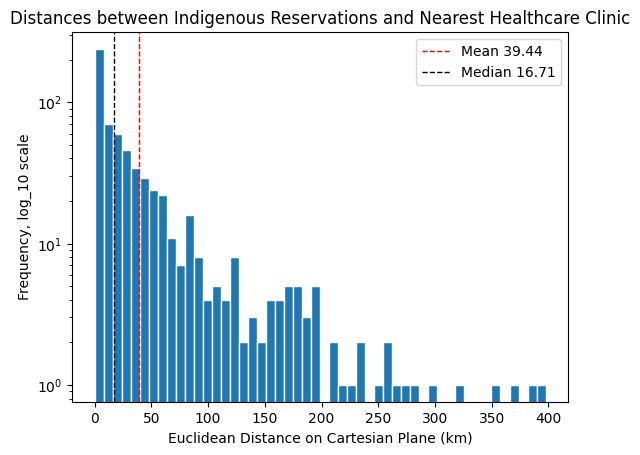

In [27]:
# plotting frequencies of min_dists
plt.hist(min_dists, bins=50, edgecolor='white')
plt.ylabel('Frequency, log_10 scale')
plt.yscale('log')
plt.xlabel('Euclidean Distance on Cartesian Plane (km)')
plt.title('Distances between Indigenous Reservations and Nearest Healthcare Clinic')

# plotting mean and median lines
dist_mean = min_dists.mean()
dist_median = statistics.median(min_dists)
plt.axvline(dist_mean, color='red', linestyle='dashed', linewidth=1,label='Mean '+str(round(dist_mean,2)))
plt.axvline(dist_median, color='black', linestyle='dashed', linewidth=1,label='Median '+str(round(dist_median,2)))

plt.legend()